<img src='./img/intel-logo.jpg' width=50%, Fig1> 

# OpenCV 기초강좌 

<font size=5><b>05. Fourier Transformation <b></font>

<div align='right'>성  민  석 (Minsuk  Sung)</div>
<div align='right'>류  회  성 (Hoesung Ryu)</div>

<img src='./img/OpenCV_Logo_with_text.png' width=20%, Fig2> 


---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#들어가기-앞서" data-toc-modified-id="들어가기-앞서-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>들어가기 앞서</a></span></li><li><span><a href="#Numpy를-이용한-퓨리에변환" data-toc-modified-id="Numpy를-이용한-퓨리에변환-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Numpy를 이용한 퓨리에변환</a></span></li><li><span><a href="#OpenCV를-이용한-퓨리에-변환" data-toc-modified-id="OpenCV를-이용한-퓨리에-변환-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>OpenCV를 이용한 퓨리에 변환</a></span></li></ul></div>

## 들어가기 앞서
<img src='./img/fourier transform.png' width=60%>

수학에서는 어떤 문제를 풀기가 어려운 경우, 다른 형태으로 변형하여 문제를 해결하는 경우가 많습니다. 푸리에 변환(Fourier Transform)도 마찬가지로 Frequency domain <-> time domain로 변환을 통하여 수학적으로 문제를 해결하는 방법입니다.

<img src='./img/fourier_pipeline.png' width=90%>
그렇다면, 이미지에서 푸리에 변환은 어떻게 적용이 될까요? 이미지도 파동으로 변환을 할 수가 있는데, 주변 픽셀과의 밝기 변환가 많은 곳은 고주파로, 변환이 적은 곳은 저주파로 표현이 가능합니다.

즉, 이미지에서 고주파의 의미는 경계선을 의미하고, 저주파는 배경을 의미합니다. 그러므로 고주파를 제거하면 경계선이 사라지고, 저주파를 제거하면 경계선만 남게 됩니다.


## Numpy를 이용한 퓨리에변환 

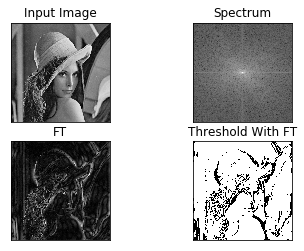

In [3]:

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("./img/lenna.png")
b,g,r = cv2.split(img)
img = cv2.merge([r,g,b])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
"""
# Fourier Transform을 적용.
 적용을 하면 0,0, 즉 화면 좌측상단점이 중심이고, 거기에 저주파가 모여 있음.
 분석을 용이하게 하기 위해 0,0을 이미지의 중심으로 이동 시키고 Log Scaling을 하여 분석이 용이한 결과값으로 변환
"""
f = np.fft.fft2(img) # 이미지에 푸리에 변환 적용
fshift = np.fft.fftshift(f) #분석을 용이하게 하기 위해 주파수가 0인 부분을 중앙에 위치시킴. 중앙에 저주파가 모이게 됨.
magnitude_spectrum = 20*np.log(np.abs(fshift)) #spectrum 구하는 수학식.

rows, cols = img.shape
crow, ccol = int(rows/2), int(cols/2) # 이미지의 중심 좌표

# 중앙에서 10X10 사이즈의 사각형의 값을 1로 설정함. 중앙의 저주파를 모두 제거
# 저주파를 제거하였기 때문에 배경이 사라지고 경계선만 남게 됨.
d = 10
fshift[crow-d:crow+d, ccol-d:ccol+d] = 1

#푸리에 변환결과를 다시 이미지로 변환
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

#threshold를 적용하기 위해 float type을 int type으로 변환
img_new = np.uint8(img_back);
ret, thresh = cv2.threshold(img_new,30,255,cv2.THRESH_BINARY_INV)

plt.subplot(221),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(222),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(223),plt.imshow(img_back, cmap = 'gray')
plt.title('FT'), plt.xticks([]), plt.yticks([])

plt.subplot(224),plt.imshow(thresh, cmap = 'gray')
plt.title('Threshold With FT'), plt.xticks([]), plt.yticks([])
plt.show()

## OpenCV를 이용한 퓨리에 변환  

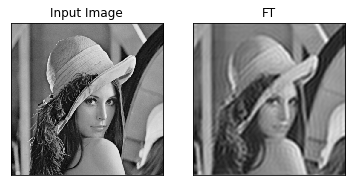

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
img = cv2.imread("./img/lenna.png",0)
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)

dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)

# 아래는 d 사이지의 사각형을 생성한 후, 사각형 바깥쪽을 제거하는 형태임.
# 즉, 고주파영역을 제거하게 됨.
# d값이 작을수록 사각형이 작고, 바깥영역 즉, 고주파영역이  많이 제거되기 때문에 이미지가 뭉게지고
# d값이 클수록 사각형이 크고, 바깥영역 즉, 고주파 영역이 적게 제거되기 때문에 원래 이미지와 가까워짐.

d = 30
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-d:crow+d, ccol-d:ccol+d] = 1
# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('FT'), plt.xticks([]), plt.yticks([])
plt.show()
